## Normal VAE

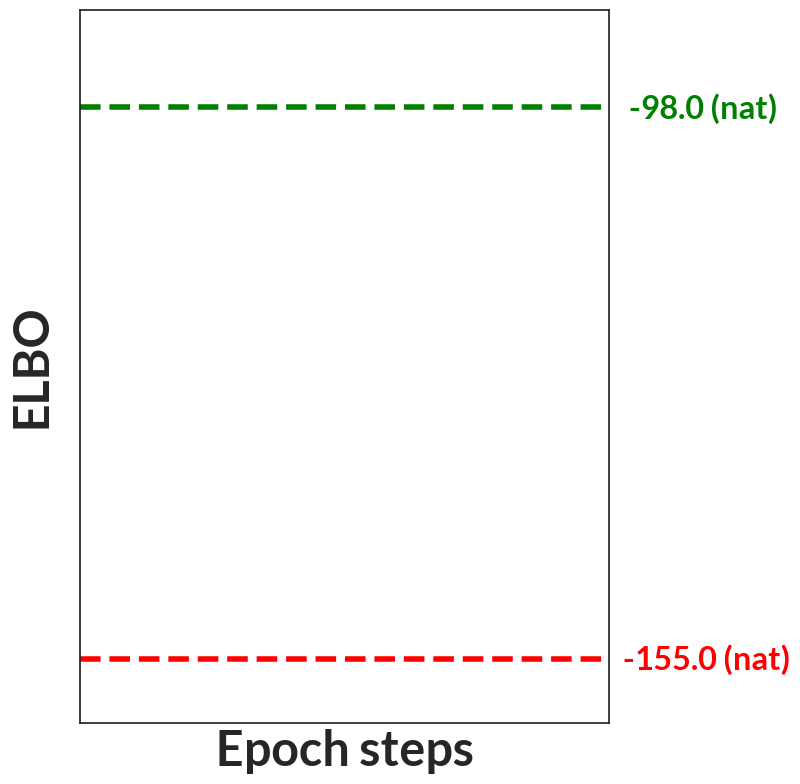

In [1]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata


import genjax
from genjax import grasp
from genjax import gensp
from genjax import select

import adevjax

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name
rcParams["figure.autolayout"] = True
label_fontsize = 70  # Set the desired font size here


def show_image(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img, cmap="gray_r")


def save_images(imgs, path):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")
    fig.savefig(path, format="pdf")


hidden_dim = 400
z_dim = 10
learning_rate = 1.0e-3
batch_size = 64
num_epochs = 200

# Loss figure.
loss_fig, loss_ax = plt.subplots(figsize=(8, 8))
loss_ax.set_xlim(0, 205)
loss_ax.set_ylim(-117.0, -95.0)
loss_ax.set_xlabel("Epoch steps", fontsize=label_fontsize / 2)
loss_ax.set_ylabel("ELBO", fontsize=label_fontsize / 2)
loss_ax.axhline(y=-115.0, color="red", linestyle="--", lw=4)
loss_ax.axhline(y=-98.0, color="green", linestyle="--", lw=4)
loss_ax.text(
    275,
    -115.5,
    "-155.0 (nat)",
    color="red",
    va="bottom",
    ha="right",
    fontsize=label_fontsize / 3,
)
loss_ax.text(
    270,
    -98.5,
    "-98.0 (nat)",
    color="green",
    va="bottom",
    ha="right",
    fontsize=label_fontsize / 3,
)
loss_ax.set_xticks([])
loss_ax.set_yticks([])
loss_ax.yaxis.labelpad = 18  # adjust the value as needed

iwae_iters = [2, 5, 10, 20]
colormap = plt.cm.magma
colors = colormap(np.linspace(0, 1, 1 + 2 * len(iwae_iters)))

In [ ]:
def encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


def decoder(hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
    )


tfp_flip = genjax.TFPDistribution(
    lambda logits: tfp.distributions.Bernoulli(logits=logits)
)

# Define our gradient estimator using our loss language.
def svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        data = genjax.choice_map({"image": data.reshape((28 * 28,))})
        objective = grasp.elbo(model, guide, data)
        loss, (
            (decoder_params_grad,),
            (encoder_params_grad, _),
        ) = objective.value_and_grad_estimate(
            key, ((decoder_params,), (encoder_params, data))
        )

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


@jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    logits = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


@genjax.gen
def guide(encoder_params, chm):
    image = chm["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = grasp.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


adam = optim.Adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


# Train.
key = random.PRNGKey(314159)
svi_state = adam.init((encoder_params, decoder_params))
elbo_losses = []
for idx in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    if idx % 50 == 0:
        print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))
    elbo_losses.append(jnp.mean(loss))

loss_ax.scatter(
    jnp.arange(num_epochs),
    jnp.array(elbo_losses),
    color=colors[0],
    marker=".",
    label="ELBO",
    s=240,
)
loss_fig

-189.18715 -150.14207 -547.16425
-102.84966 -90.544205 -116.68284
-100.86324 -90.14816 -112.83219
-100.098236 -88.28134 -110.836784


In [ ]:
def generate_images(key, n_images, svi_state):
    images = []
    for i in range(0, n_images):
        key, sub_key = jax.random.split(key)
        _, updated_decoder_params = adam.get_params(svi_state)
        latent = genjax.tfp_mv_normal_diag.sample(
            key, jnp.zeros(z_dim), jnp.ones(z_dim)
        )
        updated_out = jax.nn.sigmoid(
            decoder_nn_apply(updated_decoder_params, latent)
        ).reshape(28, 28)
        images.append(updated_out)
    return images


sub_key = jax.random.PRNGKey(314159)
imgs = generate_images(sub_key, 4, svi_state)
save_images(imgs, "img/elbo_samples.pdf")

## IWAE

In [ ]:
# Define our gradient estimator using our loss language.
def iwae_svi_update(
    model,
    guide,
    optimizer,
    n_particles,
):
    def _inner(key, encoder_params, decoder_params, data):
        data = genjax.choice_map({"image": data.reshape((28 * 28,))})
        objective = grasp.iwae_elbo(model, guide, data, n_particles)
        loss, (
            (decoder_params_grad,),
            (encoder_params_grad, _),
        ) = objective.value_and_grad_estimate(
            key, ((decoder_params,), (encoder_params, data))
        )

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


for (color_idx, i) in enumerate(iwae_iters):
    adam = optim.Adam(learning_rate)
    iwae_svi_updater = iwae_svi_update(model, guide, adam, i)

    # Reset training.
    train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
    num_train, train_idx = train_init()
    rng_key = PRNGKey(0)
    encoder_init_key, decoder_init_key = random.split(rng_key)
    _, encoder_params = encoder_nn_init(encoder_init_key, (784,))
    _, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
    num_train, train_idx = train_init()

    @jit
    def epoch_train(svi_state, key1, key2, train_idx):
        def body_fn(carry, xs):
            idx, svi_state, loss = carry
            rng_key_binarize = random.fold_in(key1, idx)
            batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
            updater_key = random.fold_in(key2, idx)
            svi_state, loss = iwae_svi_updater(updater_key, svi_state, batch)
            idx += 1
            return (idx, svi_state, loss), loss

        idx = 0
        (_, svi_state, _), losses = lax.scan(
            body_fn, (idx, svi_state, 0.0), None, length=num_train
        )
        return svi_state, losses

    # Train.
    key = random.PRNGKey(314159)
    svi_state = adam.init((encoder_params, decoder_params))
    iwae_elbo_losses = []
    for idx in range(0, num_epochs):
        key, key1, key2 = jax.random.split(key, 3)
        num_train, train_idx = train_init()
        svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
        if idx % 50 == 0:
            print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))
        iwae_elbo_losses.append(jnp.mean(loss))

    loss_ax.scatter(
        jnp.arange(num_epochs),
        jnp.array(iwae_elbo_losses),
        color=colors[color_idx + 1],
        marker=".",
        label=f"IWAE ELBO (n = {i})",
        s=240,
    )

font_properties = {"size": label_fontsize / 3, "weight": "bold"}
loss_ax.legend(prop=font_properties)
loss_fig.savefig("img/vae_elbo_plot.pdf", format="pdf")

In [ ]:
sub_key = jax.random.PRNGKey(314159)
imgs = generate_images(sub_key, 4, svi_state)
save_images(imgs, "img/iwae_elbo_20_samples.pdf")